In [1]:
# Importar TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Sequential, optimizers
from tensorflow.keras import layers, models, Sequential, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array

# Librerías para preprocesamiento y métricas
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configuración de TensorFlow
print("Versión de TensorFlow:", tf.__version__)
print("¿TensorFlow está usando GPU?")
print(tf.config.list_physical_devices('GPU'))

Versión de TensorFlow: 2.10.0
¿TensorFlow está usando GPU?
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Configuración de rutas
data_paths = {
    "Mel-512": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Spectrograms\\Mel-512",
    "Mel-1024": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Spectrograms\\Mel-1024",
    "Mel-2048": "..\\Analisis_Espectros\\DataSetImages_FULL\DataSetImages\\Spectrograms\\Mel-2048",
    "Bump": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Scalograms\\Bump",
    "Morlet": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Scalograms\\Morlet"  
}

In [4]:
def load_and_preprocess_data(data_path, batch_size=50, img_size=(224, 224)):
    # Cargar datasets de entrenamiento y validación
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=img_size,
        batch_size=batch_size
    )
    raw_val_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=img_size,
        batch_size=batch_size
    )

    # Extraer nombres de las clases
    class_names = raw_train_ds.class_names

    # Normalizar los datos
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
    train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))

    # Prefetch para optimizar
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, val_ds, class_names

In [5]:
def create_model(num_classes):
    # Cargar VGG16 preentrenada
    base_model = VGG16(
        weights="imagenet",         # Pesos preentrenados en ImageNet
        include_top=False,          # Excluir las capas densas superiores
        input_shape=(224, 224, 3)   # Tamaño de entrada para VGG16
    )
    base_model.trainable = False   # Congelar las capas base

    # Añadir capas personalizadas
    model = models.Sequential([
        base_model,
        layers.Flatten(),          # VGG16 requiere aplanar las salidas
        layers.Dense(256, activation="relu"),  # Capa densa intermedia
        layers.Dropout(0.5),       # Regularización
        layers.Dense(num_classes, activation="softmax")  # Capa de salida
    ])
    return model

In [6]:
# Función para entrenar el modelo (Transfer Learning)
def train_model(model, train_ds, val_ds, epochs=30):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history

In [7]:
def fine_tune_model(model, train_ds, val_ds, base_learning_rate=0.0001, fine_tune_at=12):
    # Descongelar la base del modelo
    model.layers[0].trainable = True

    # Congelar las primeras capas según sea necesario
    for layer in model.layers[0].layers[:fine_tune_at]:
        layer.trainable = False

    # Compilar el modelo para ajuste fino
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    # Entrenamiento
    history = model.fit(train_ds, validation_data=val_ds, epochs=35)
    return history

In [8]:
def generate_classification_report(model, val_ds, class_names, title=""):
    y_true = []
    y_pred = []

    # Obtener predicciones
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    # Reporte de clasificación
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print(f"\nReporte de Clasificación para {title}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return report

In [9]:
# Función para graficar métricas de entrenamiento
def plot_training_history(history, title=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Procesando representación: Mel-512
Found 5363 files belonging to 7 classes.
Using 4291 files for training.
Found 5363 files belonging to 7 classes.
Using 1072 files for validation.
Epoch 1/30
86/86 [==============================] - 39s 300ms/step - loss: 1.8274 - accuracy: 0.3423 - val_loss: 1.3231 - val_accuracy: 0.5271
Epoch 2/30
86/86 [==============================] - 19s 214ms/step - loss: 1.3328 - accuracy: 0.4866 - val_loss: 1.0032 - val_accuracy: 0.6828
Epoch 3/30
86/86 [==============================] - 19s 223ms/step - loss: 1.1733 - accuracy: 0.5365 - val_loss: 0.9160 - val_accuracy: 0.6866
Epoch 4/30
86/86 [==============================] - 20s 232ms/step - loss: 1.0980 - accuracy: 0.5754 - val_loss: 0.8257 - val_accuracy: 0.7472
Epoch 5/30
86/86 [==============================] - 20s 236ms/step - loss: 1.0286 - accuracy: 0.5856 - val_loss: 0.7664 - val_accuracy: 0.7715
Epoch 6/30
86/86 [==============================] - 21s 234ms/step - loss: 0.9544 - accuracy: 0.6309 - v

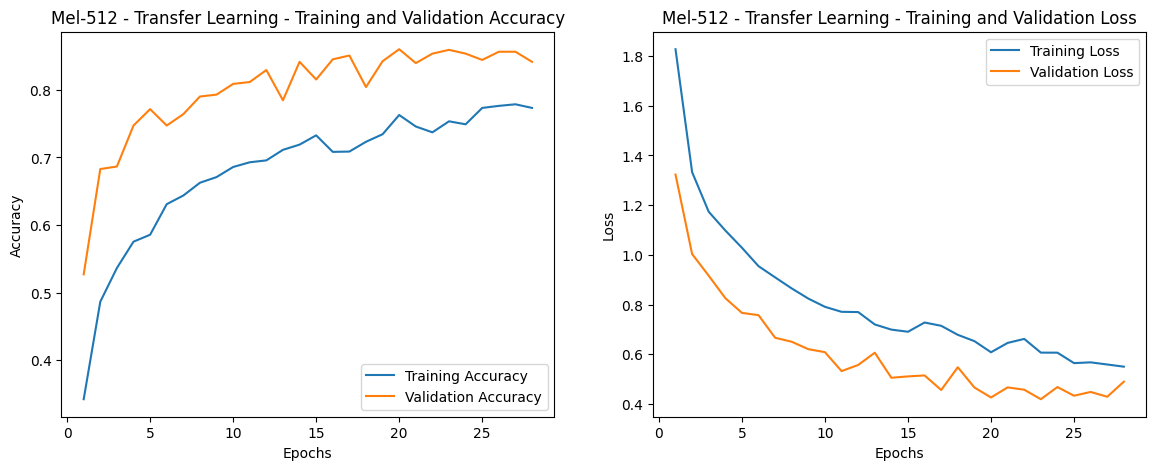

1/1 [==============================] - 0s 22ms/step

Reporte de Clasificación para Mel-512 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.82      0.85      0.83       143
children_playing       0.81      0.74      0.77       133
        drilling       0.94      0.83      0.88       168
   engine_idling       0.86      0.89      0.87       150
      jackhammer       0.89      0.97      0.93       156
           siren       0.93      0.88      0.90       161
    street_music       0.77      0.85      0.81       161

        accuracy                           0.86      1072
       macro avg       0.86      0.86      0.86      1072
    weighted avg       0.86      0.86      0.86      1072



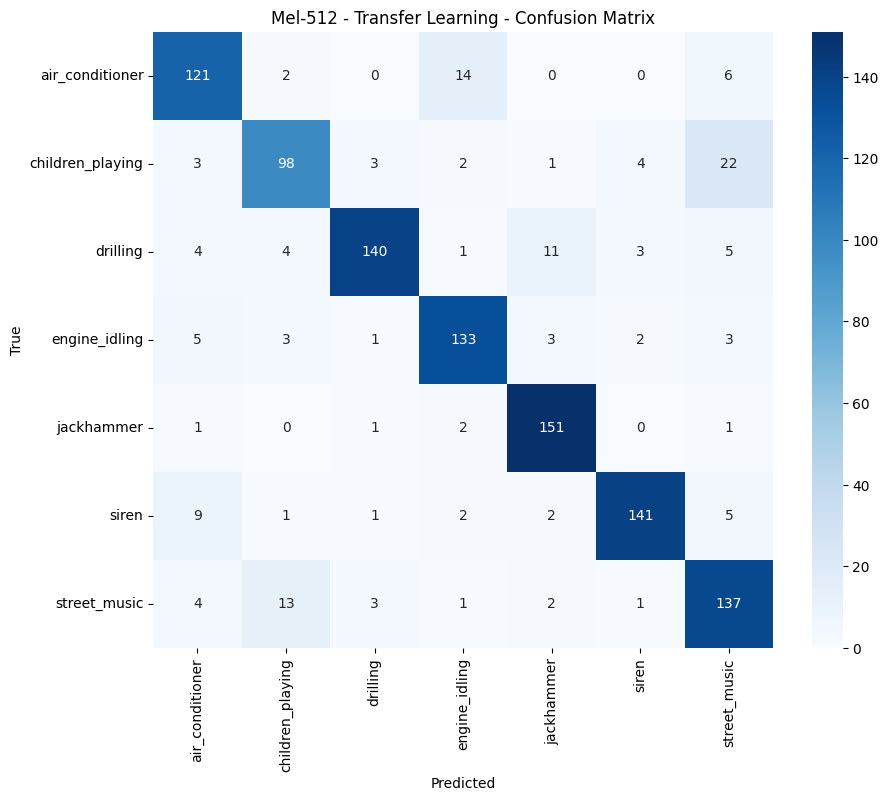

Epoch 1/35
86/86 [==============================] - 37s 353ms/step - loss: 0.5524 - accuracy: 0.7786 - val_loss: 0.3980 - val_accuracy: 0.8741
Epoch 2/35
86/86 [==============================] - 28s 320ms/step - loss: 0.4914 - accuracy: 0.8035 - val_loss: 0.3703 - val_accuracy: 0.8825
Epoch 3/35
86/86 [==============================] - 28s 327ms/step - loss: 0.4617 - accuracy: 0.8119 - val_loss: 0.3644 - val_accuracy: 0.8909
Epoch 4/35
86/86 [==============================] - 27s 315ms/step - loss: 0.4619 - accuracy: 0.8087 - val_loss: 0.3442 - val_accuracy: 0.8983
Epoch 5/35
86/86 [==============================] - 28s 321ms/step - loss: 0.4374 - accuracy: 0.8247 - val_loss: 0.3294 - val_accuracy: 0.8927
Epoch 6/35
86/86 [==============================] - 27s 315ms/step - loss: 0.4234 - accuracy: 0.8238 - val_loss: 0.3769 - val_accuracy: 0.8871
Epoch 7/35
86/86 [==============================] - 28s 323ms/step - loss: 0.4186 - accuracy: 0.8320 - val_loss: 0.2944 - val_accuracy: 0.9049

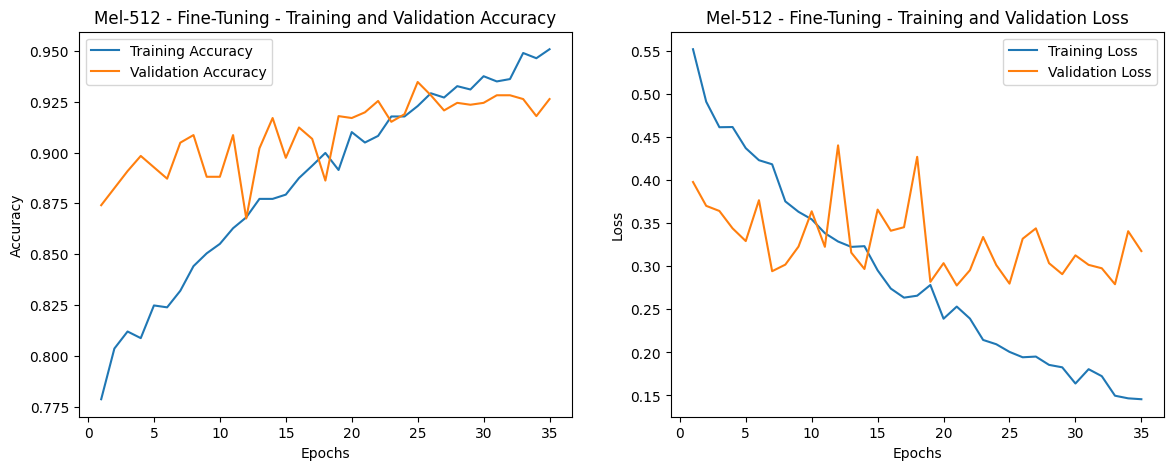

1/1 [==============================] - 0s 45ms/step

Reporte de Clasificación para Mel-512 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.96      0.93      0.94       143
children_playing       0.82      0.86      0.84       133
        drilling       0.97      0.93      0.95       168
   engine_idling       0.96      0.91      0.94       150
      jackhammer       0.94      0.96      0.95       156
           siren       0.98      0.96      0.97       161
    street_music       0.86      0.91      0.89       161

        accuracy                           0.93      1072
       macro avg       0.93      0.92      0.93      1072
    weighted avg       0.93      0.93      0.93      1072



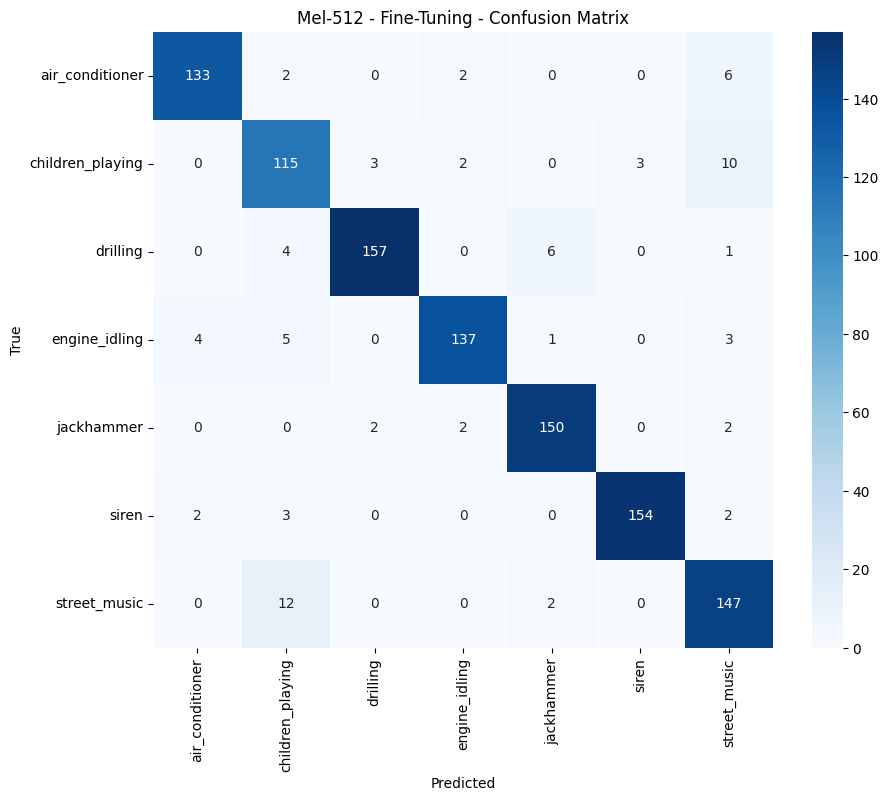

Procesando representación: Mel-1024
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
Epoch 1/30
86/86 [==============================] - 28s 309ms/step - loss: 1.7067 - accuracy: 0.3895 - val_loss: 1.1438 - val_accuracy: 0.6250
Epoch 2/30
86/86 [==============================] - 22s 243ms/step - loss: 1.2033 - accuracy: 0.5331 - val_loss: 0.8844 - val_accuracy: 0.7164
Epoch 3/30
86/86 [==============================] - 21s 242ms/step - loss: 1.0371 - accuracy: 0.6007 - val_loss: 0.7597 - val_accuracy: 0.7276
Epoch 4/30
86/86 [==============================] - 22s 243ms/step - loss: 0.9541 - accuracy: 0.6403 - val_loss: 0.7596 - val_accuracy: 0.7593
Epoch 5/30
86/86 [==============================] - 22s 247ms/step - loss: 0.8731 - accuracy: 0.6762 - val_loss: 0.6404 - val_accuracy: 0.7631
Epoch 6/30
86/86 [==============================] - 21s 243ms/step - loss: 0.7906 - accuracy: 0.6981 - 

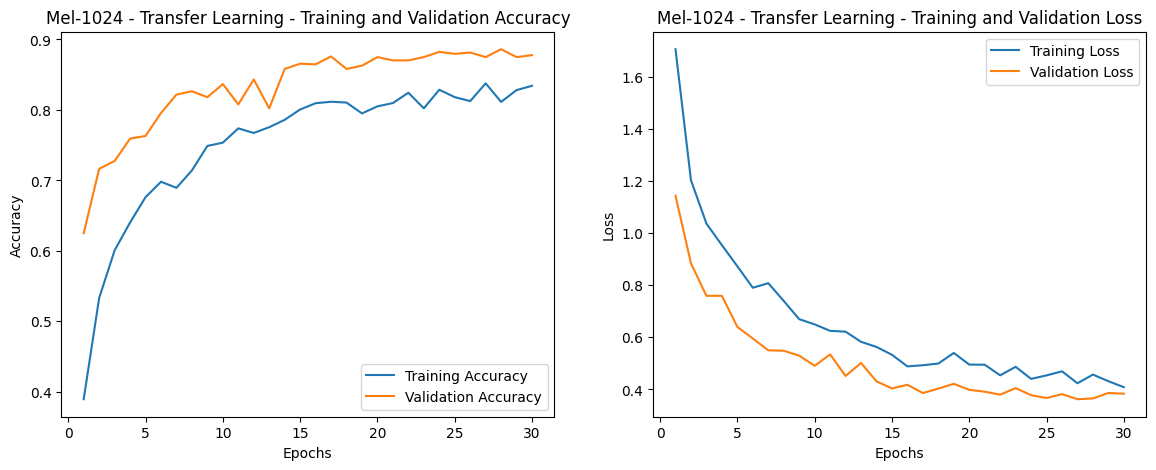

1/1 [==============================] - 0s 26ms/step

Reporte de Clasificación para Mel-1024 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.78      0.92      0.85       143
children_playing       0.78      0.84      0.81       133
        drilling       0.95      0.88      0.92       168
   engine_idling       0.93      0.81      0.87       149
      jackhammer       0.94      0.92      0.93       157
           siren       0.87      0.94      0.90       161
    street_music       0.90      0.83      0.86       161

        accuracy                           0.88      1072
       macro avg       0.88      0.88      0.88      1072
    weighted avg       0.88      0.88      0.88      1072



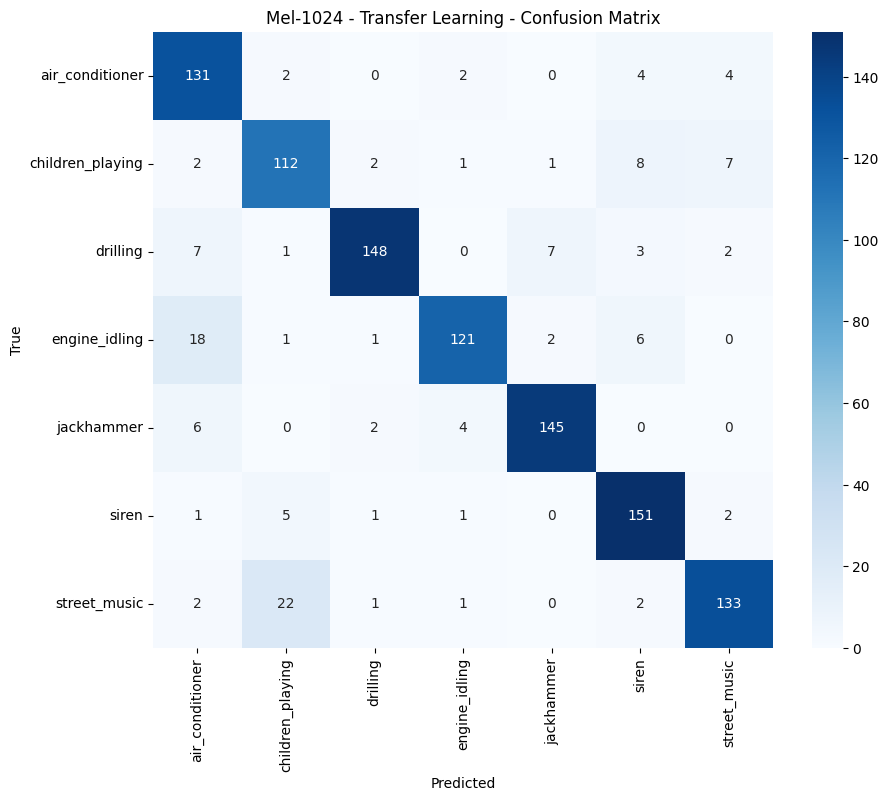

Epoch 1/35
86/86 [==============================] - 32s 358ms/step - loss: 0.3989 - accuracy: 0.8380 - val_loss: 0.3417 - val_accuracy: 0.9058
Epoch 2/35
86/86 [==============================] - 28s 320ms/step - loss: 0.3296 - accuracy: 0.8727 - val_loss: 0.3369 - val_accuracy: 0.9142
Epoch 3/35
86/86 [==============================] - 27s 317ms/step - loss: 0.2834 - accuracy: 0.8928 - val_loss: 0.3136 - val_accuracy: 0.9132
Epoch 4/35
86/86 [==============================] - 29s 330ms/step - loss: 0.2587 - accuracy: 0.9009 - val_loss: 0.3088 - val_accuracy: 0.9198
Epoch 5/35
86/86 [==============================] - 28s 317ms/step - loss: 0.2459 - accuracy: 0.9082 - val_loss: 0.2728 - val_accuracy: 0.9235
Epoch 6/35
86/86 [==============================] - 29s 331ms/step - loss: 0.2173 - accuracy: 0.9170 - val_loss: 0.3417 - val_accuracy: 0.9188
Epoch 7/35
86/86 [==============================] - 28s 322ms/step - loss: 0.1949 - accuracy: 0.9259 - val_loss: 0.2791 - val_accuracy: 0.9282

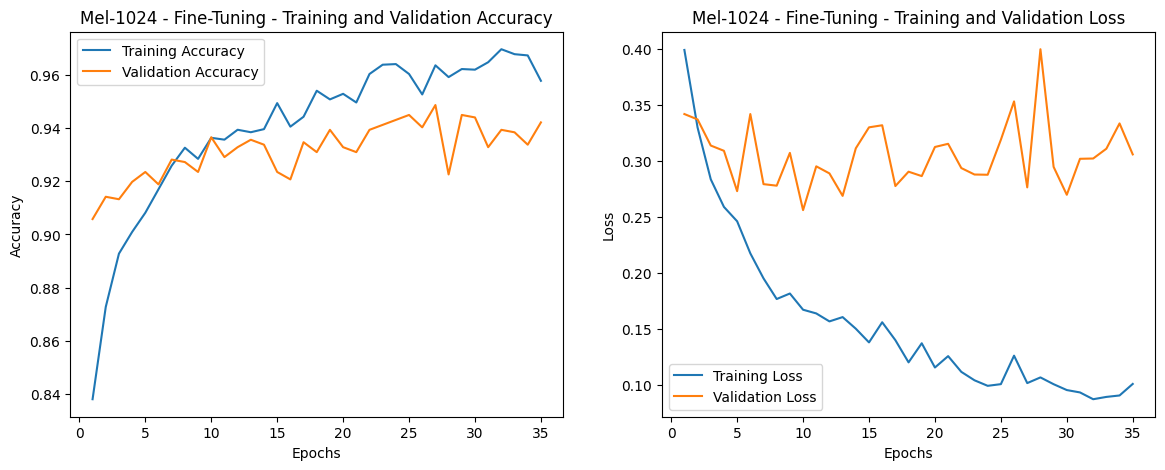

1/1 [==============================] - 0s 39ms/step

Reporte de Clasificación para Mel-1024 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.93      0.99      0.96       143
children_playing       0.94      0.86      0.90       133
        drilling       0.90      0.96      0.93       168
   engine_idling       0.98      0.94      0.96       149
      jackhammer       0.98      0.93      0.95       157
           siren       0.95      0.97      0.96       161
    street_music       0.93      0.93      0.93       161

        accuracy                           0.94      1072
       macro avg       0.94      0.94      0.94      1072
    weighted avg       0.94      0.94      0.94      1072



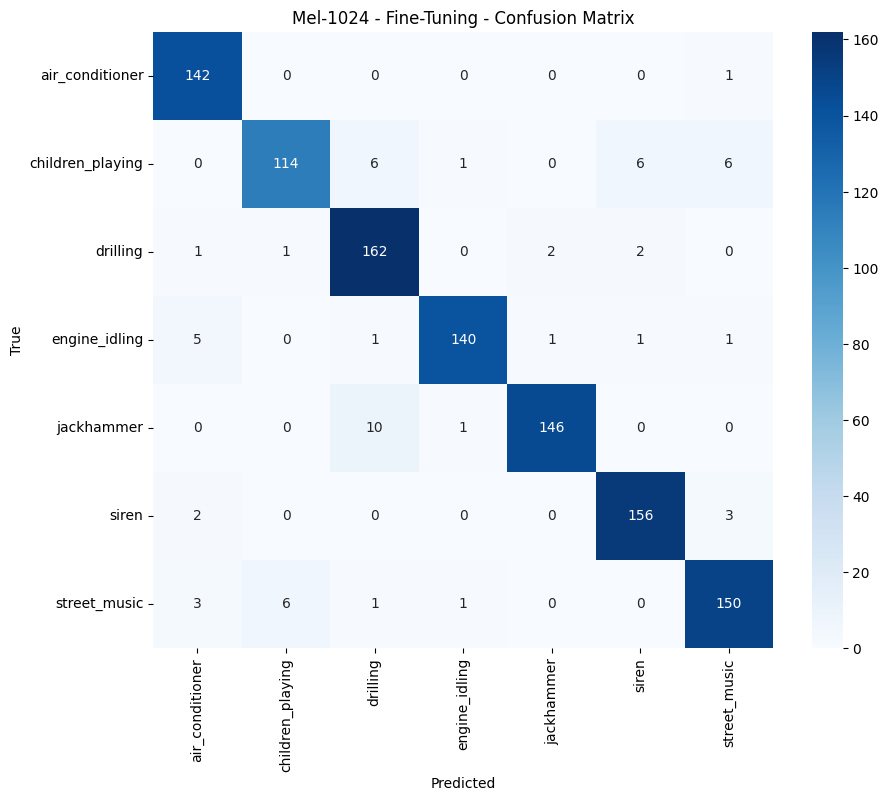

Procesando representación: Mel-2048
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
Epoch 1/30
86/86 [==============================] - 21s 234ms/step - loss: 1.6916 - accuracy: 0.3839 - val_loss: 1.0880 - val_accuracy: 0.6371
Epoch 2/30
86/86 [==============================] - 21s 238ms/step - loss: 1.1676 - accuracy: 0.5455 - val_loss: 0.9222 - val_accuracy: 0.7071
Epoch 3/30
86/86 [==============================] - 21s 230ms/step - loss: 1.0302 - accuracy: 0.6012 - val_loss: 0.7569 - val_accuracy: 0.7677
Epoch 4/30
86/86 [==============================] - 21s 232ms/step - loss: 0.9316 - accuracy: 0.6366 - val_loss: 0.7042 - val_accuracy: 0.7621
Epoch 5/30
86/86 [==============================] - 21s 242ms/step - loss: 0.8703 - accuracy: 0.6648 - val_loss: 0.6876 - val_accuracy: 0.7929
Epoch 6/30
86/86 [==============================] - 21s 240ms/step - loss: 0.8515 - accuracy: 0.6683 - 

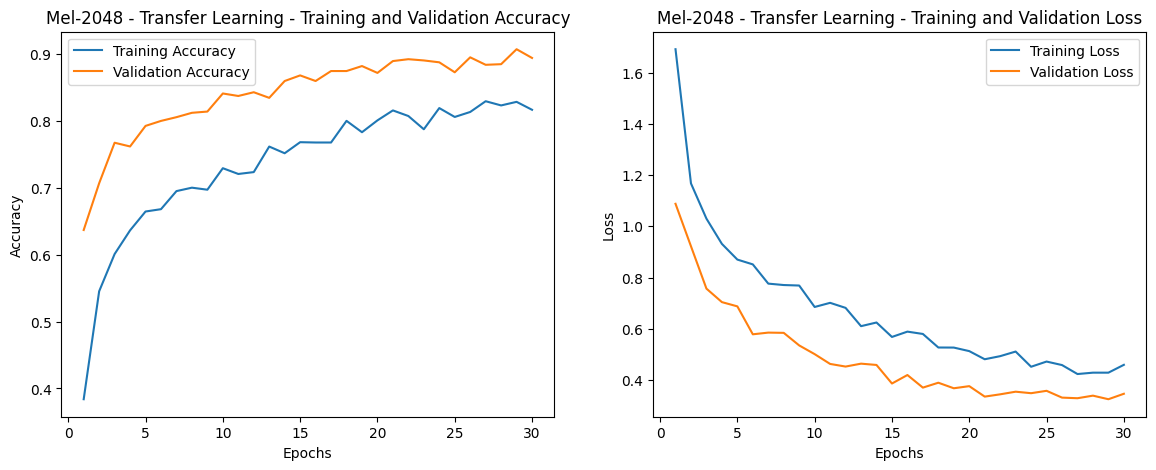

1/1 [==============================] - 0s 77ms/step

Reporte de Clasificación para Mel-2048 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.87      0.92      0.90       143
children_playing       0.84      0.81      0.82       133
        drilling       0.95      0.92      0.93       168
   engine_idling       0.86      0.91      0.89       149
      jackhammer       0.96      0.92      0.94       157
           siren       0.93      0.88      0.90       161
    street_music       0.84      0.89      0.87       161

        accuracy                           0.89      1072
       macro avg       0.89      0.89      0.89      1072
    weighted avg       0.90      0.89      0.89      1072



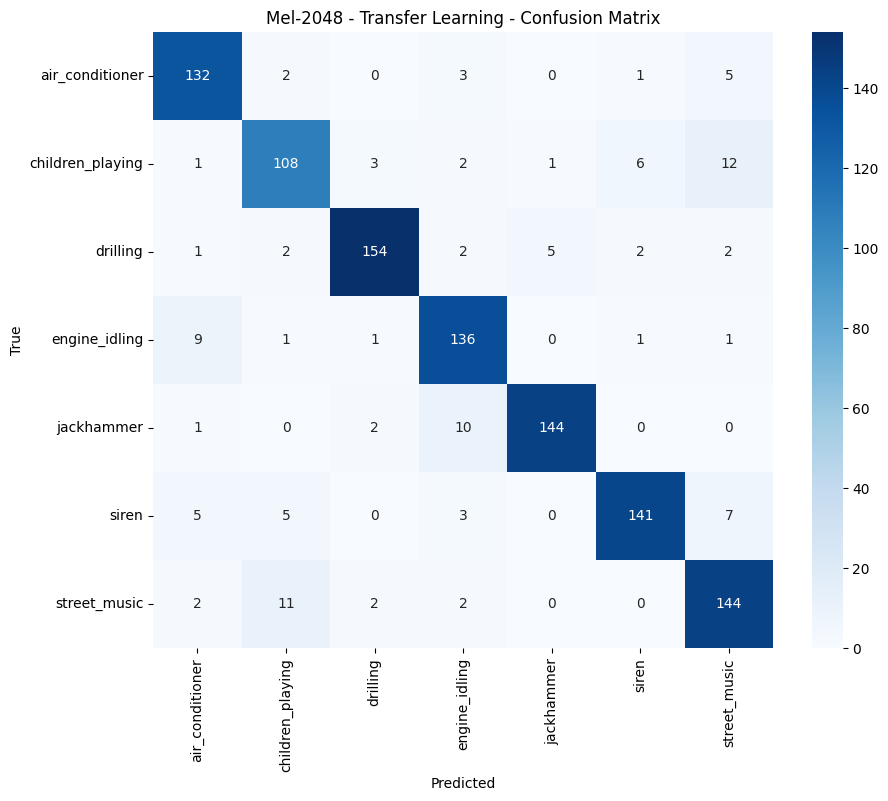

Epoch 1/35
86/86 [==============================] - 28s 313ms/step - loss: 0.4254 - accuracy: 0.8245 - val_loss: 0.3228 - val_accuracy: 0.8918
Epoch 2/35
86/86 [==============================] - 28s 321ms/step - loss: 0.3809 - accuracy: 0.8483 - val_loss: 0.3312 - val_accuracy: 0.8983
Epoch 3/35
86/86 [==============================] - 28s 325ms/step - loss: 0.3474 - accuracy: 0.8578 - val_loss: 0.2769 - val_accuracy: 0.9179
Epoch 4/35
86/86 [==============================] - 29s 330ms/step - loss: 0.3352 - accuracy: 0.8657 - val_loss: 0.3178 - val_accuracy: 0.9076
Epoch 5/35
86/86 [==============================] - 27s 311ms/step - loss: 0.3061 - accuracy: 0.8720 - val_loss: 0.2605 - val_accuracy: 0.9226
Epoch 6/35
86/86 [==============================] - 28s 318ms/step - loss: 0.2781 - accuracy: 0.8867 - val_loss: 0.2736 - val_accuracy: 0.9160
Epoch 7/35
86/86 [==============================] - 28s 318ms/step - loss: 0.2699 - accuracy: 0.8909 - val_loss: 0.2469 - val_accuracy: 0.9226

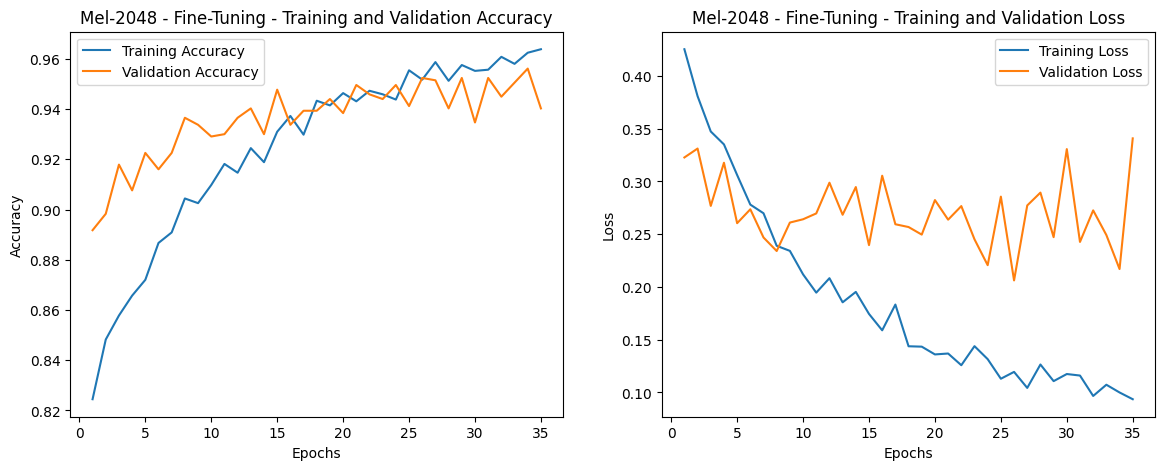

1/1 [==============================] - 0s 44ms/step

Reporte de Clasificación para Mel-2048 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.92      0.99      0.95       143
children_playing       0.93      0.84      0.89       133
        drilling       0.94      0.97      0.96       168
   engine_idling       0.95      0.96      0.96       149
      jackhammer       0.96      0.97      0.97       157
           siren       0.93      0.98      0.95       161
    street_music       0.94      0.86      0.90       161

        accuracy                           0.94      1072
       macro avg       0.94      0.94      0.94      1072
    weighted avg       0.94      0.94      0.94      1072



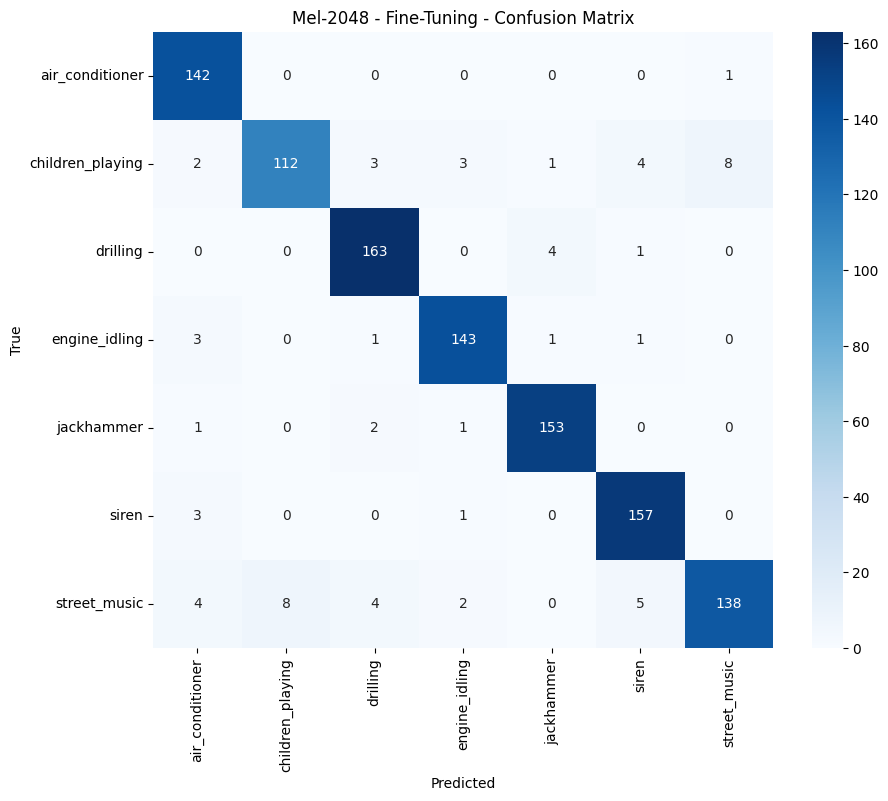

Procesando representación: Bump
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
Epoch 1/30
86/86 [==============================] - 23s 250ms/step - loss: 1.9905 - accuracy: 0.2368 - val_loss: 1.6470 - val_accuracy: 0.4534
Epoch 2/30
86/86 [==============================] - 23s 262ms/step - loss: 1.6470 - accuracy: 0.3228 - val_loss: 1.4584 - val_accuracy: 0.4310
Epoch 3/30
86/86 [==============================] - 22s 254ms/step - loss: 1.5504 - accuracy: 0.3550 - val_loss: 1.3412 - val_accuracy: 0.5271
Epoch 4/30
86/86 [==============================] - 22s 248ms/step - loss: 1.4698 - accuracy: 0.3867 - val_loss: 1.2454 - val_accuracy: 0.5168
Epoch 5/30
86/86 [==============================] - 22s 249ms/step - loss: 1.4448 - accuracy: 0.4012 - val_loss: 1.2015 - val_accuracy: 0.5308
Epoch 6/30
86/86 [==============================] - 22s 251ms/step - loss: 1.3875 - accuracy: 0.4142 - val_

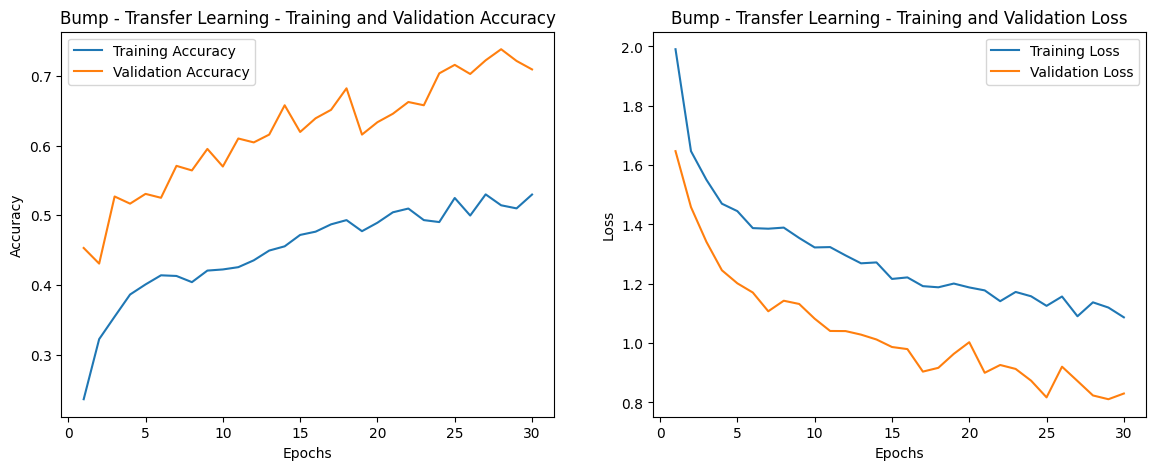

1/1 [==============================] - 0s 21ms/step

Reporte de Clasificación para Bump - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.65      0.61      0.63       143
children_playing       0.51      0.80      0.62       133
        drilling       0.91      0.74      0.81       168
  engine_idiling       0.70      0.60      0.64       149
      jackhammer       0.65      0.97      0.78       157
           siren       0.95      0.80      0.86       161
    street_music       0.76      0.45      0.57       161

        accuracy                           0.71      1072
       macro avg       0.73      0.71      0.70      1072
    weighted avg       0.74      0.71      0.71      1072



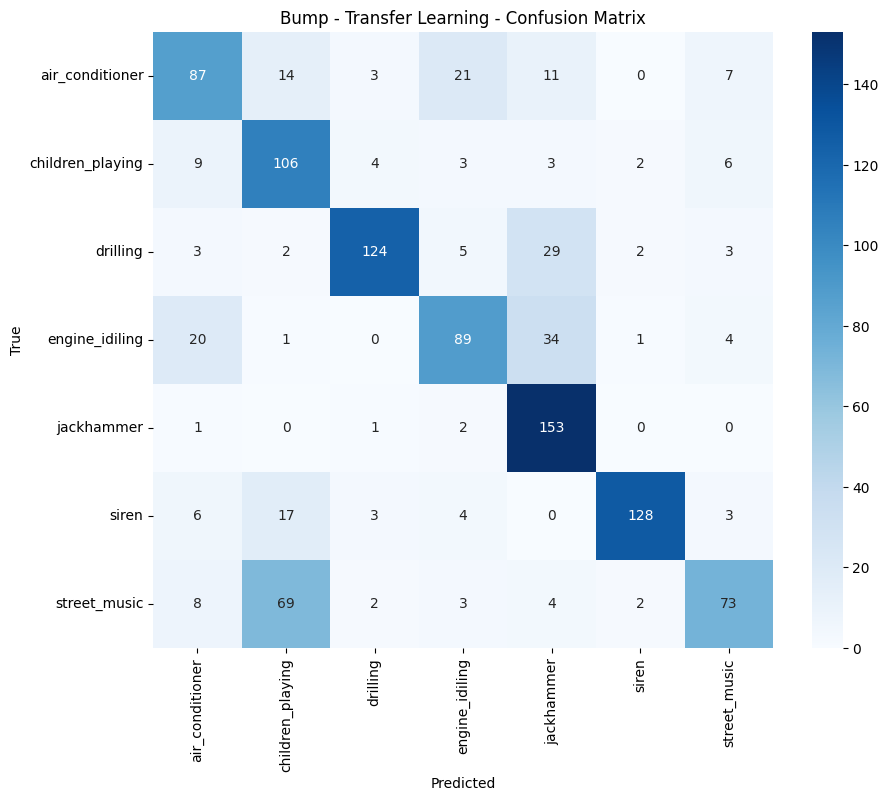

Epoch 1/35
86/86 [==============================] - 28s 318ms/step - loss: 1.0648 - accuracy: 0.5401 - val_loss: 0.8179 - val_accuracy: 0.7463
Epoch 2/35
86/86 [==============================] - 28s 321ms/step - loss: 0.9868 - accuracy: 0.5793 - val_loss: 0.7323 - val_accuracy: 0.7696
Epoch 3/35
86/86 [==============================] - 28s 316ms/step - loss: 0.9505 - accuracy: 0.5795 - val_loss: 0.6548 - val_accuracy: 0.8069
Epoch 4/35
86/86 [==============================] - 28s 322ms/step - loss: 0.9072 - accuracy: 0.5902 - val_loss: 0.6287 - val_accuracy: 0.7882
Epoch 5/35
86/86 [==============================] - 28s 317ms/step - loss: 0.8788 - accuracy: 0.6159 - val_loss: 0.6240 - val_accuracy: 0.8218
Epoch 6/35
86/86 [==============================] - 28s 324ms/step - loss: 0.8728 - accuracy: 0.6140 - val_loss: 0.6198 - val_accuracy: 0.8293
Epoch 7/35
86/86 [==============================] - 29s 329ms/step - loss: 0.8519 - accuracy: 0.6203 - val_loss: 0.6114 - val_accuracy: 0.8172

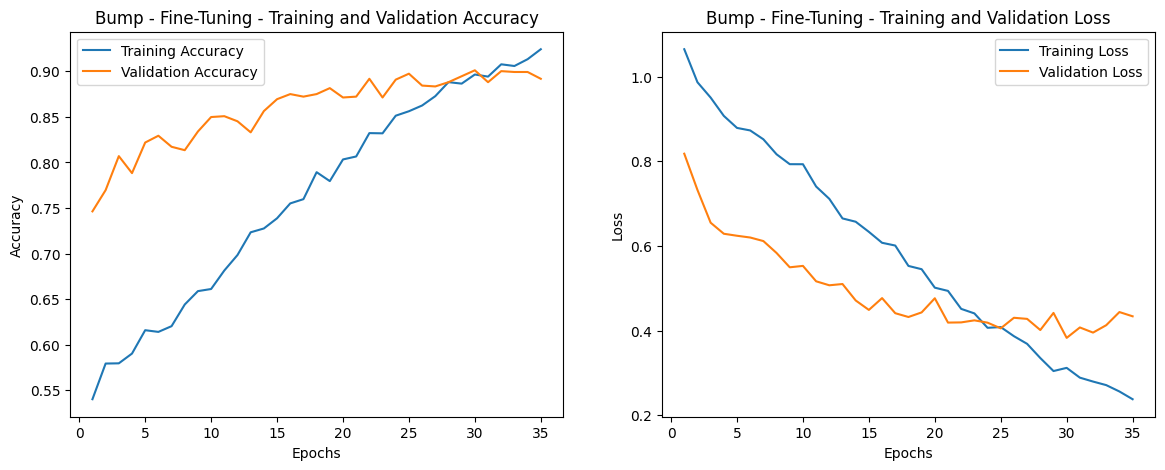

1/1 [==============================] - 0s 27ms/step

Reporte de Clasificación para Bump - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.77      0.97      0.86       143
children_playing       0.82      0.77      0.80       133
        drilling       0.90      0.96      0.93       168
  engine_idiling       0.91      0.86      0.89       149
      jackhammer       0.96      0.95      0.96       157
           siren       0.97      0.90      0.94       161
    street_music       0.90      0.82      0.86       161

        accuracy                           0.89      1072
       macro avg       0.89      0.89      0.89      1072
    weighted avg       0.90      0.89      0.89      1072



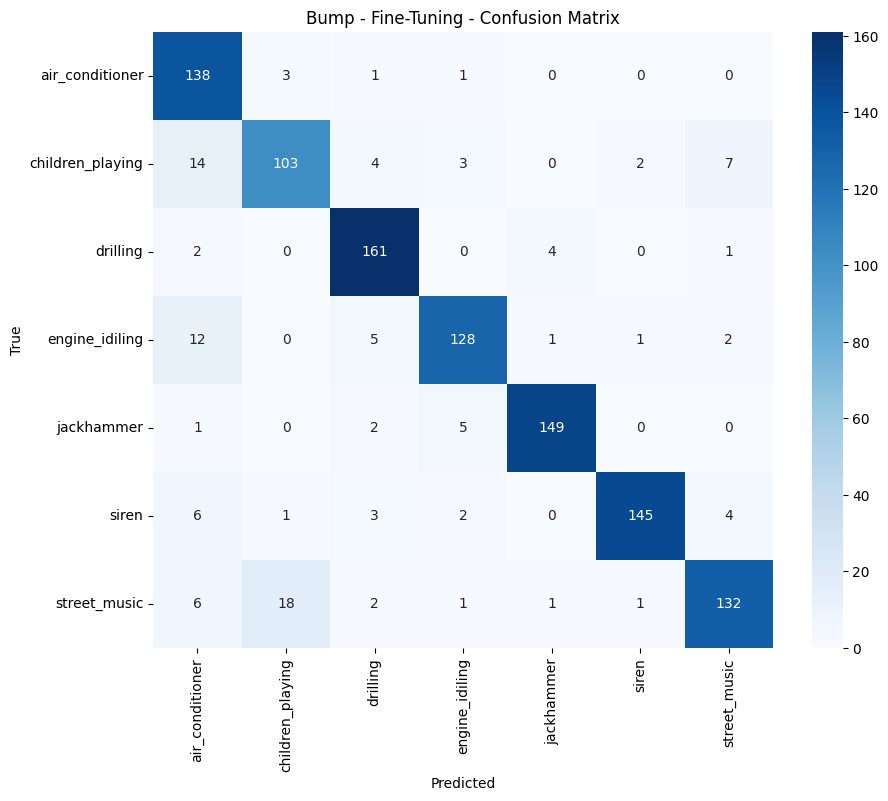

Procesando representación: Morlet
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
Epoch 1/30
86/86 [==============================] - 23s 251ms/step - loss: 1.9268 - accuracy: 0.2263 - val_loss: 1.6017 - val_accuracy: 0.4580
Epoch 2/30
86/86 [==============================] - 21s 238ms/step - loss: 1.6010 - accuracy: 0.3128 - val_loss: 1.4430 - val_accuracy: 0.4412
Epoch 3/30
86/86 [==============================] - 22s 247ms/step - loss: 1.5266 - accuracy: 0.3429 - val_loss: 1.3773 - val_accuracy: 0.4897
Epoch 4/30
86/86 [==============================] - 22s 256ms/step - loss: 1.5085 - accuracy: 0.3578 - val_loss: 1.3797 - val_accuracy: 0.4720
Epoch 5/30
86/86 [==============================] - 23s 270ms/step - loss: 1.4750 - accuracy: 0.3683 - val_loss: 1.3174 - val_accuracy: 0.5336
Epoch 6/30
86/86 [==============================] - 23s 270ms/step - loss: 1.4571 - accuracy: 0.3718 - va

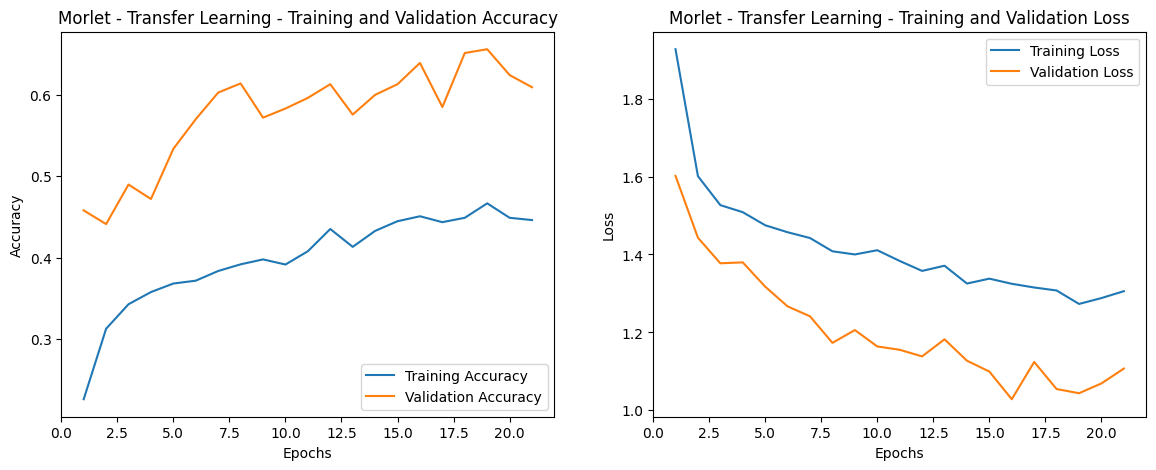

1/1 [==============================] - 0s 29ms/step

Reporte de Clasificación para Morlet - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.43      0.50      0.46       143
children_playing       0.66      0.56      0.61       133
        drilling       0.90      0.67      0.76       168
  engine_idiling       0.44      0.34      0.38       149
      jackhammer       0.58      0.79      0.67       157
           siren       0.89      0.79      0.84       161
    street_music       0.64      0.78      0.70       161

        accuracy                           0.64      1072
       macro avg       0.65      0.63      0.63      1072
    weighted avg       0.66      0.64      0.64      1072



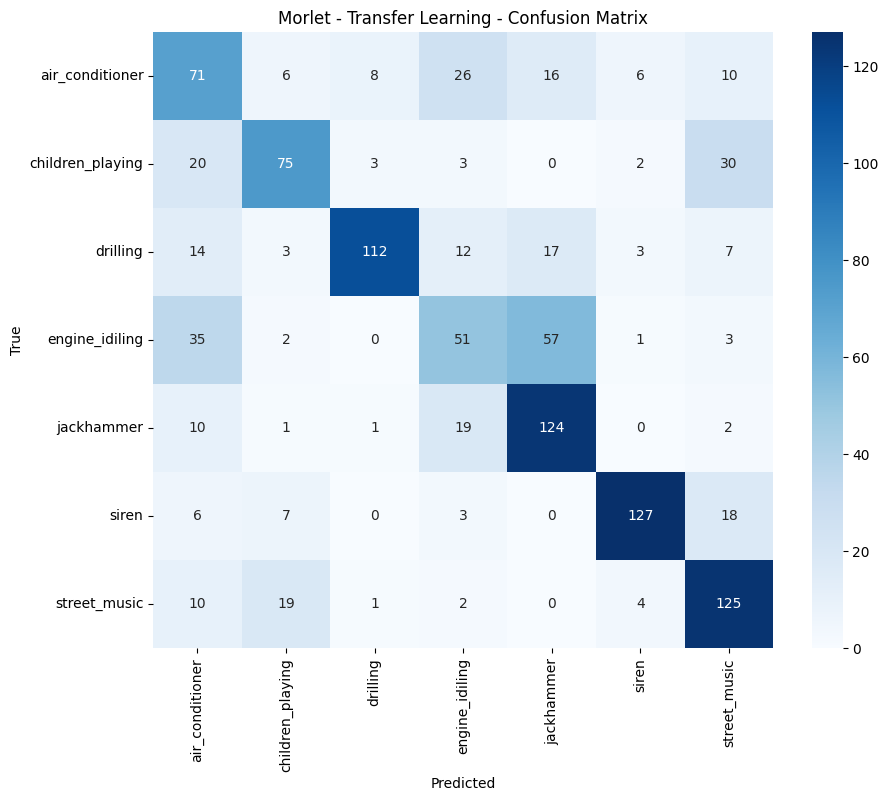

Epoch 1/35
86/86 [==============================] - 31s 342ms/step - loss: 1.3157 - accuracy: 0.4483 - val_loss: 0.9912 - val_accuracy: 0.6791
Epoch 2/35
86/86 [==============================] - 29s 330ms/step - loss: 1.2345 - accuracy: 0.4702 - val_loss: 0.9736 - val_accuracy: 0.6866
Epoch 3/35
86/86 [==============================] - 31s 348ms/step - loss: 1.1910 - accuracy: 0.4867 - val_loss: 0.9405 - val_accuracy: 0.6847
Epoch 4/35
86/86 [==============================] - 30s 346ms/step - loss: 1.1766 - accuracy: 0.5089 - val_loss: 0.9566 - val_accuracy: 0.6772
Epoch 5/35
86/86 [==============================] - 30s 341ms/step - loss: 1.1150 - accuracy: 0.5268 - val_loss: 0.9151 - val_accuracy: 0.6530
Epoch 6/35
86/86 [==============================] - 30s 341ms/step - loss: 1.1028 - accuracy: 0.5317 - val_loss: 0.8846 - val_accuracy: 0.6959
Epoch 7/35
86/86 [==============================] - 30s 346ms/step - loss: 1.0810 - accuracy: 0.5613 - val_loss: 0.7987 - val_accuracy: 0.7388

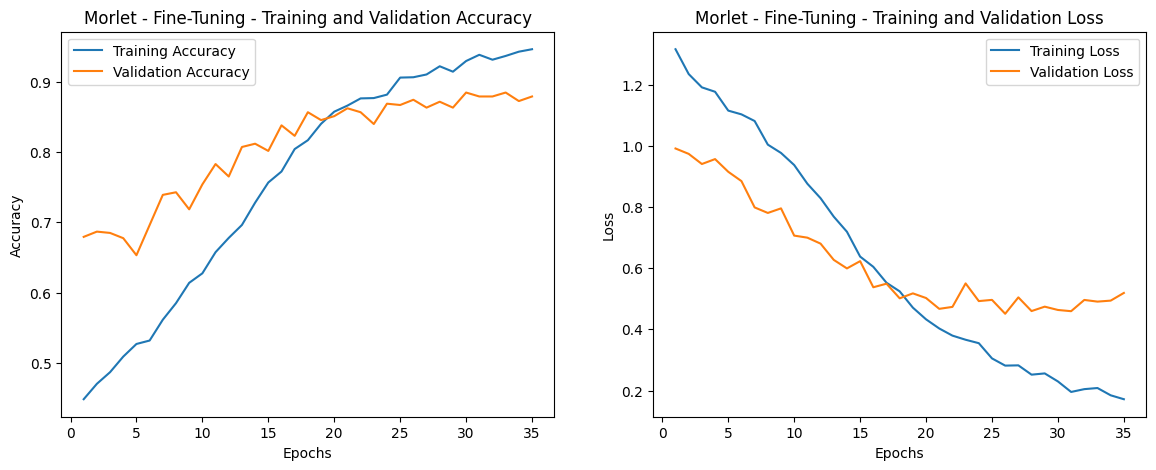

1/1 [==============================] - 0s 72ms/step

Reporte de Clasificación para Morlet - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.87      0.83      0.85       143
children_playing       0.85      0.71      0.77       133
        drilling       0.86      0.95      0.90       168
  engine_idiling       0.89      0.89      0.89       149
      jackhammer       0.91      0.96      0.93       157
           siren       0.94      0.91      0.92       161
    street_music       0.83      0.87      0.85       161

        accuracy                           0.88      1072
       macro avg       0.88      0.87      0.87      1072
    weighted avg       0.88      0.88      0.88      1072



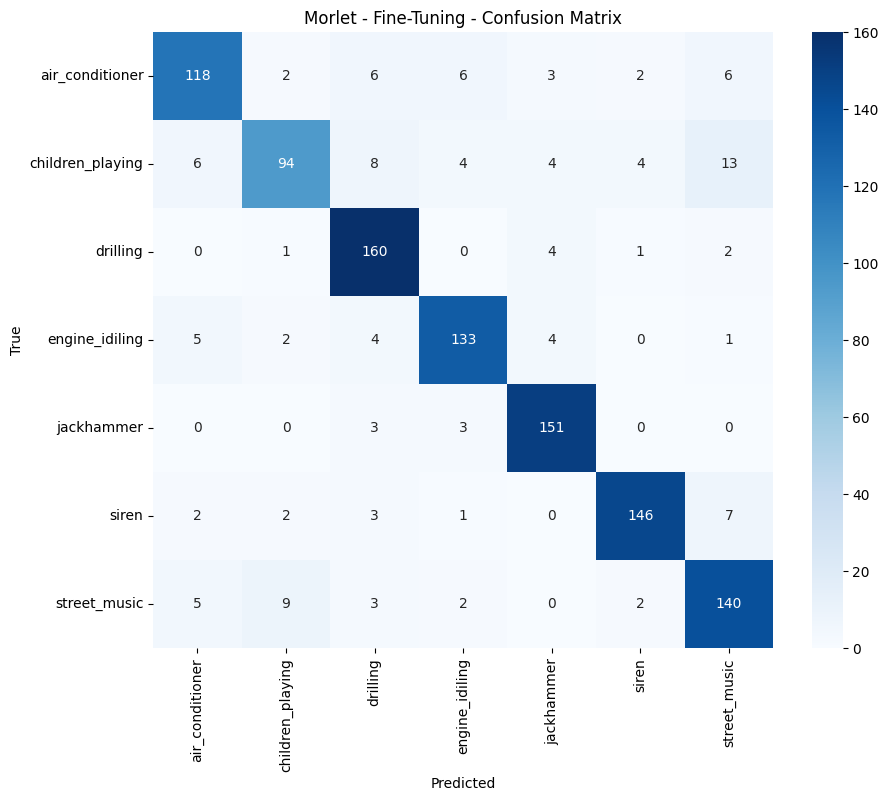

In [10]:
# Lista para almacenar los resultados
final_results = []
for representation, data_path in data_paths.items():
    print(f"Procesando representación: {representation}")

    # Cargar datos y obtener class_names
    train_ds, val_ds, class_names = load_and_preprocess_data(data_path)
    num_classes = len(class_names)

    # Crear y entrenar modelo
    model = create_model(num_classes)
    history = train_model(model, train_ds, val_ds)
    plot_training_history(history, title=f"{representation} - Transfer Learning")

    # Generar reporte y matriz de confusión (Transfer Learning)
    report = generate_classification_report(model, val_ds, class_names, title=f"{representation} - Transfer Learning")

    # Guardar resultados iniciales
    final_results.append({
        "Representation": representation,
        "Stage": "Transfer Learning",
        "Accuracy": report["accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"]
    })

    # Fine-tuning
    fine_tune_history = fine_tune_model(model, train_ds, val_ds)
    plot_training_history(fine_tune_history, title=f"{representation} - Fine-Tuning")

    # Generar reporte y matriz de confusión (Fine-Tuning)
    fine_tune_report = generate_classification_report(model, val_ds, class_names, title=f"{representation} - Fine-Tuning")

    # Guardar resultados Fine-Tuning
    final_results.append({
        "Representation": representation,
        "Stage": "Fine-Tuning",
        "Accuracy": fine_tune_report["accuracy"],
        "Macro F1": fine_tune_report["macro avg"]["f1-score"],
        "Weighted F1": fine_tune_report["weighted avg"]["f1-score"]
    })

    # Guardar modelo
    model.save(f"model_{representation}.keras")

In [11]:
# Crear DataFrame consolidado
df_results = pd.DataFrame(final_results)

# Mostrar el reporte completo
print("\n**Reporte Consolidado:**\n")
print(df_results)

# Calcular puntaje combinado (promedio de todas las métricas)
df_results["Average Score"] = df_results[["Accuracy", "Macro F1", "Weighted F1"]].mean(axis=1)

# Determinar el mejor modelo en base al puntaje combinado
best_model = df_results.sort_values(by="Average Score", ascending=False).iloc[0]

# Mostrar el mejor modelo
print("\n**Mejor Representación (Basado en Todas las Métricas):**")
print(best_model)


**Reporte Consolidado:**

  Representation              Stage  Accuracy  Macro F1  Weighted F1
0        Mel-512  Transfer Learning  0.859142  0.856808     0.859098
1        Mel-512        Fine-Tuning  0.926306  0.925118     0.926994
2       Mel-1024  Transfer Learning  0.877799  0.876053     0.878416
3       Mel-1024        Fine-Tuning  0.942164  0.941431     0.941961
4       Mel-2048  Transfer Learning  0.894590  0.893020     0.894902
5       Mel-2048        Fine-Tuning  0.940299  0.938542     0.939489
6           Bump  Transfer Learning  0.708955  0.703093     0.707597
7           Bump        Fine-Tuning  0.891791  0.888941     0.891899
8         Morlet  Transfer Learning  0.638993  0.632136     0.639115
9         Morlet        Fine-Tuning  0.878731  0.874441     0.877300

**Mejor Representación (Basado en Todas las Métricas):**
Representation       Mel-1024
Stage             Fine-Tuning
Accuracy             0.942164
Macro F1             0.941431
Weighted F1          0.941961
Averag

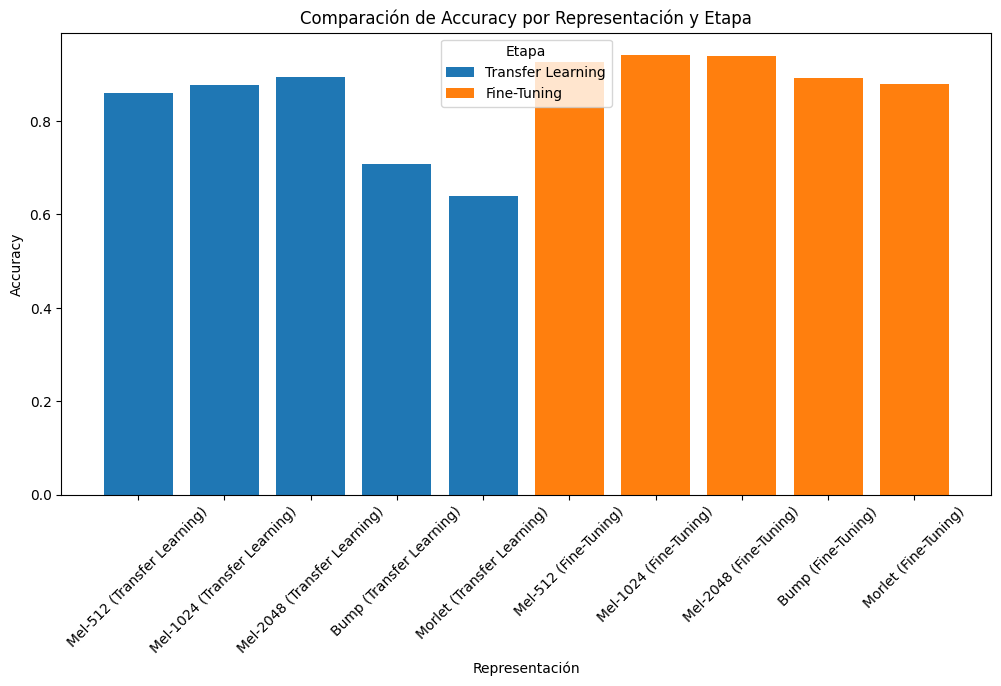

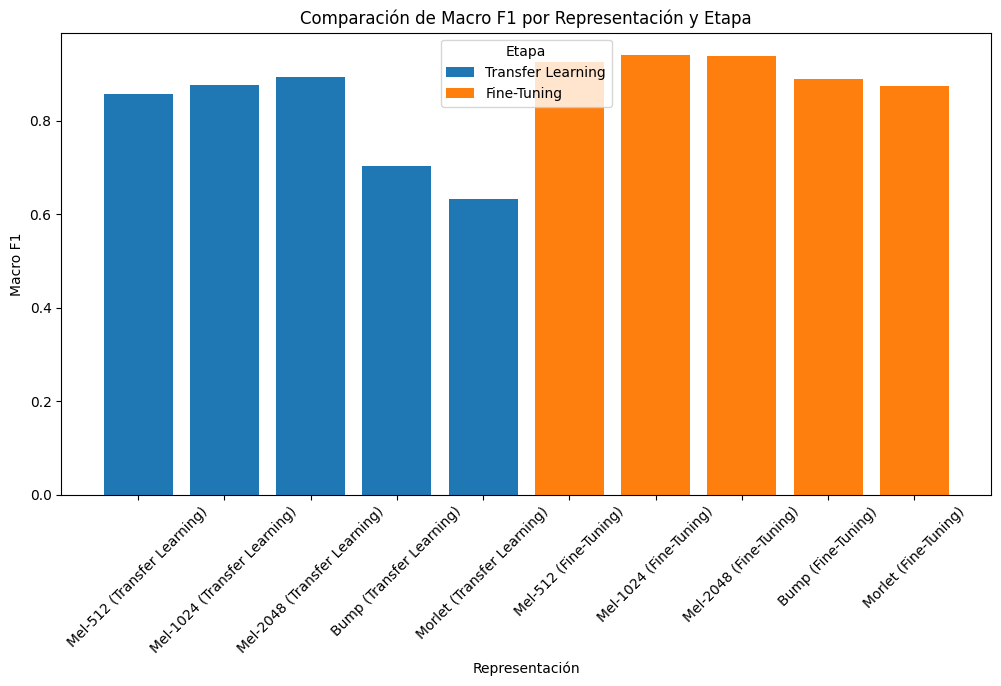

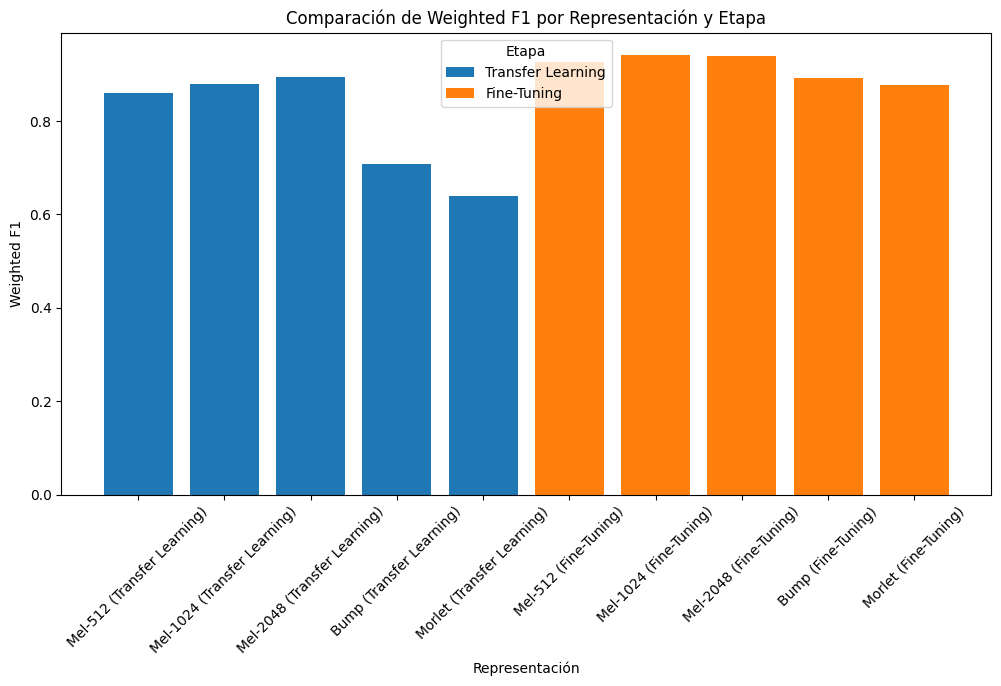

In [12]:
# Gráficos comparativos por métrica
metrics = ["Accuracy", "Macro F1", "Weighted F1"]
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for stage in df_results["Stage"].unique():
        stage_data = df_results[df_results["Stage"] == stage]
        plt.bar(stage_data["Representation"] + f" ({stage})", stage_data[metric], label=stage)

    plt.title(f"Comparación de {metric} por Representación y Etapa")
    plt.xlabel("Representación")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title="Etapa")
    plt.show()

In [13]:
# Ordenar resultados por puntaje promedio
df_results_sorted = df_results.sort_values(by="Average Score", ascending=False)

# Mostrar la tabla final ordenada
print("\n**Tabla de Resultados Ordenada por Puntaje Promedio:**\n")
print(df_results_sorted)


**Tabla de Resultados Ordenada por Puntaje Promedio:**

  Representation              Stage  Accuracy  Macro F1  Weighted F1  \
3       Mel-1024        Fine-Tuning  0.942164  0.941431     0.941961   
5       Mel-2048        Fine-Tuning  0.940299  0.938542     0.939489   
1        Mel-512        Fine-Tuning  0.926306  0.925118     0.926994   
4       Mel-2048  Transfer Learning  0.894590  0.893020     0.894902   
7           Bump        Fine-Tuning  0.891791  0.888941     0.891899   
2       Mel-1024  Transfer Learning  0.877799  0.876053     0.878416   
9         Morlet        Fine-Tuning  0.878731  0.874441     0.877300   
0        Mel-512  Transfer Learning  0.859142  0.856808     0.859098   
6           Bump  Transfer Learning  0.708955  0.703093     0.707597   
8         Morlet  Transfer Learning  0.638993  0.632136     0.639115   

   Average Score  
3       0.941852  
5       0.939443  
1       0.926139  
4       0.894171  
7       0.890877  
2       0.877422  
9       0.876824 